# Evolutionary rescue of positive interactions - Data handling

This notebook contains a parser for raw simulation results and plotting of rescue probabilities of different interactions

Raw data is in the form of binary sequence where 0 is extinction and 1 is rescue. Data stemmed for multiple parameter simulations (run with nested loops) is in the form of 1d sequence with linear indexing (param1,param2,rounds).


Data used in the paper and it's corresponding figures can be found in the data folder.

Parameters table can be found in **table S1** in the supplementary information:

https://www.biorxiv.org/content/10.1101/2020.08.06.239608v1

In [6]:
# Imports

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [10]:
def parse_table(data,rounds,params):
    ''' 
    Parser of raw data
        data - Raw data
        rounds - Number of rounds for each parameter combination
        params - Dictionary in which the key is the parameter name (string) and the value is the parameters used (array)
    return a table with the parameters and the corresponding evolutionary rescue probability 
    '''

    keys = list(params.keys())
    values = list(params.values())
    param_nums = np.array([val.shape[0] for val in values])
    ps = np.zeros(np.prod(param_nums))
    
    for i,res in enumerate(np.array(np.split(data,np.prod(param_nums)))):
        
        rounds_cur = rounds
        not_ended = np.sum(res==-1)
        
        if not_ended:
            print('Warning - '+ str(not_ended)+ ' simulations did not end')
            rounds_cur=rounds - np.sum(res==-1)
        
        ps[i] = res.sum()/rounds_cur
        
    df = pd.DataFrame(data=ps,columns=['Rescue probability'])
    
    if len(keys)>1:
        df[keys[0]] = np.ravel([param_nums[1]*[j] for j in values[0]])

        df[keys[1]] = np.ravel(param_nums[0]*[values[1]])
    else:
        df[keys[0]] = values[0]
    return df

In [108]:
def plot_data(data):
    ''' 
    Plot rescue probabilities
        data - Dictionary in which the key is the interaction name (string) and the value is the data (parsed table)
    '''    
    
    
    interactions = list(data.keys())
    rows = np.max([table.shape[0] for table in list(data.values())])
    ps = np.full([len(interactions),rows],np.NAN)
    for i,table in enumerate(list(data.values())):
        size = table.shape[0]
        ps[i][:size] = table['Rescue probability']

    plot_data = pd.DataFrame(ps,index=interactions).T.melt(var_name='Interaction type',value_name='Rescue probability')
    sns.swarmplot(data=plot_data,x='Interaction type',y='Rescue probability')  
    ax=sns.boxplot(data=plot_data,x='Interaction type',y='Rescue probability', color='whitesmoke',showfliers = False)


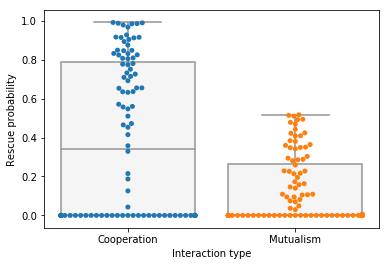

In [110]:
#### Example of usage with cooperation and mutualism data ####

# Number of rounds for each parameter combination
rounds=1000

# Parameters used in simulation
d=1
Ncs=np.array([1,50,100,500,1000,5000,10000,50000,100000,500000])
rms = np.array(np.arange(1.4,2.6,0.13))/1.3
rs = np.array(np.arange(0.84,1.3,0.05))/1.3
div_r = np.array([np.round((rms[i]-d)/(d-rs[i]),1) for i in range(rms.shape[0])])

# Create parameters dictionary (in the order of the loop)
params = {'Nc':Ncs,'Growth ratios':div_r}

# Parse data
data_coop = np.loadtxt('../Data/Main/Raw/Cooperation_main.txt')
parsed_coop = parse_table(data_coop,rounds,params)

data_mutualism = np.loadtxt('../Data/Main/Raw/Mutualism_main.txt')
parsed_mut = parse_table(data_mutualism,rounds,params)

# Creat dictionary for plot

data_all = {'Cooperation':parsed_coop,'Mutualism':parsed_mut}

plot_data(data_all)
